In [1]:
import os
from numpy import sqrt
from pyroot_module import *


Welcome to JupyROOT 6.15/01
#include "/home/santiago/MG5_aMC_v2_6_5/Delphes/classes/DelphesClasses.h"
#include "/home/santiago/MG5_aMC_v2_6_5/ExRootAnalysis/ExRootTreeReader.h"
Delphes classes imported


### Setting PATH and loading libraries for Delphes and ExRootAnalysis 

In [2]:
#path of folder to save the images
imgPath = './images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/'

# # Delphes_Path="/home/daniel/Documents/Madgraph/MG5_aMC_v2_6_6/Delphes/"
# Delphes_Path='/home/santiago/MG5_aMC_v2_6_5/Delphes'
# ROOT.gSystem.AddDynamicPath(Delphes_Path)
# ROOT.gSystem.Load("libDelphes.so");

# # ER_Path="/home/daniel/Documents/Madgraph/MG5_aMC_v2_6_6/ExRootAnalysis/"
# ER_Path="/home/santiago/MG5_aMC_v2_6_5/ExRootAnalysis/"
# ROOT.gSystem.AddDynamicPath(ER_Path)
# ROOT.gSystem.Load("libExRootAnalysis.so");

# try:
#     ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
#     ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')
#     print("Delphes classes imported")
# except:
#     pass

### Reading trees and selecting branches

In [3]:
# getting signal and background trees
# signal
backgroundPath = './data/background/'
signalPath = '/home/santiago/VBF_DMSimp_spin0_EWKExcluded/Events/run_18/'

fs = [] #Signal files
imgFold = [] #Images forlders
for f in os.listdir(signalPath):
    if os.path.isfile(signalPath + f) and '.root' in f:
        fs.append(ROOT.TFile(signalPath + f))
    
        #create folder to save images
        imgFold.append((imgPath+f).replace('.root',''))
        if not os.path.exists(imgFold[-1]):
            os.makedirs(imgFold[-1])
    
        
#Signal trees
s = [f.Get("Delphes") for f in fs]

# background
b = ROOT.TChain("Delphes")
b.Add(backgroundPath + "santiago_run_02.root") #no
b.Add(backgroundPath + "santiago_run_05.root") #no
b.Add(backgroundPath + "santiago_run_07.root") #no

# number of signal and background events 
nb = int(b.GetEntries())
ns = [int(k.GetEntries()) for k in s]

# number of bins to book histograms
nbBins = int(sqrt(nb))+1
nsBins = [int(sqrt(n))+1 for n in ns] 

# reading trees and selecting branches
treeB = ROOT.ExRootTreeReader(b)
treeS = [ROOT.ExRootTreeReader(t) for t in s]

jetB = treeB.UseBranch("Jet")
jetS = [tree.UseBranch("Jet") for tree in treeS]

metB = treeB.UseBranch("MissingET")
metS = [tree.UseBranch("MissingET") for tree in treeS]

# number of jets to use
numJets = 5

ExRootAnalysisDict dictionary payload:16:10: fatal error: 'ExRootAnalysis/ExRootTreeReader.h' file not found
#include "ExRootAnalysis/ExRootTreeReader.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Error in <TInterpreter::AutoParse>: Error parsing payload code for class ExRootTreeReader with content:

#line 1 "ExRootAnalysisDict dictionary payload"

#ifndef G__VECTOR_HAS_CLASS_ITERATOR
  #define G__VECTOR_HAS_CLASS_ITERATOR 1
#endif

#define _BACKWARD_BACKWARD_WARNING_H

/** \class ExRootAnalysisLinkDef
 *
 *  Lists classes to be included in cint dicitonary
 *
 *  \author P. Demin - UCL, Louvain-la-Neuve
 *
 */

#include "ExRootAnalysis/ExRootTreeReader.h"
#include "ExRootAnalysis/ExRootTreeWriter.h"
#include "ExRootAnalysis/ExRootTreeBranch.h"
#include "ExRootAnalysis/ExRootResult.h"
#include "ExRootAnalysis/ExRootUtilities.h"
#include "ExRootAnalysis/ExRootClassifier.h"
#include "ExRootAnalysis/ExRootFilter.h"

#include "ExRootAnalysis/ExRootProgressBar.h"
#include "ExRootAnalysis/E

### Book histograms

In [4]:
#---------------------------
#           signal
#---------------------------
hsDeltaEtaJet = [ROOT.TH1F("hsDeltaEtaJet_{0}".format(j), "Delta_Eta_Jet12_{0}".format(j), 50,0,10)
                for j in range(len(s))]

#Delta Eta for the two jets with highest invariant mass
hsDeltaEtaMaxIM = [ROOT.TH1F("hsDeltaEtaM_{0}".format(j), "Delta_Eta_M_{0}".format(j), 50,0,10) 
                   for j in range(len(s))]
hsMass = [ROOT.TH1F("hSMass_{0}".format(j), "M(j1,j2)_{0}".format(j), 65,0,4000)
         for j in range(len(s))]

# Highest invariant mass between to jets
hsMassMax = [ROOT.TH1F("hsMjj_{0}".format(j), "Max_M_{0}".format(j), 65,0,4000)
            for j in range(len(s))]

hsDeltaPhi = [ROOT.TH1F("hsDeltaPhi_{0}".format(j), "delta_Phi_{0}".format(j), 50, -1, 4)
              for j in range(len(s))]

# Delta phi for the two jets with highest invariant mass
hsDeltaPhiMax = [ROOT.TH1F("hsDeltaPhiMax_{0}".format(j), "Max_delta_phi_{0}".format(j), 50, -1, 4)
                 for j in range(len(s))]

hsDeltaPhiMetJet = [[ROOT.TH1F("hsDelPhiMet_j{0}_{1}".format(i,j),"dMetJ{0}_{1}".format(i,j), 50, -1, 4) 
                     for i in range(numJets)] 
                    for j in range(len(s))]

#---------------------------
#        background
#---------------------------
hbDeltaEtaJet = ROOT.TH1F("hbDeltaEtaJet", "Delta_Eta_Jet12", 50,0,10)
hbDeltaEtaMaxIM = ROOT.TH1F("hbDeltaEtaMaxIM", "Delta_Eta_MaxIM", 50,0,10)
hbMass = ROOT.TH1F("hbMass", "M(j1,j2)", 65,0,4000)
hbMassMax = ROOT.TH1F("hbMjj", "Max_M", 65,0,4000)
hbDeltaPhi = ROOT.TH1F("hbDeltaPhi", "delta_Phi", 50, -1, 4)
hbDeltaPhiMax = ROOT.TH1F("hbDeltaPhiMax", "Max_delta_phi", 50, -1, 4)
hbDeltaPhiMetJet = [ROOT.TH1F("hbDelPhiMet_j{0}".format(i),"dMetJ{0}".format(i), 50, -1, 4) 
                    for i in range(numJets)]

### Selecting events and filling histograms

In [5]:
# Loop over all signal events
for k in range(len(ns)):
    print(k)
    for event in range(ns[k]):
        #Load selected branches with data from specified event
        treeS[k].ReadEntry(event)

        # cuts
    #     # select events with MET > 200 GeV
    #     if metS.At(0).MET < 200: continue
        # select events with at least 2 jets
        if jetS[k].GetEntries() < 2: continue
        
    #     # select events with jets in opposite hemispheres 
    #     if (jetS.At(0).Eta * jetS.At(1).Eta) >= 0: continue
    #     # select events with jet1 and jet2 PT > 60
    #     if jetS.At(0).PT < 30: continue
    #     if jetS.At(1).PT < 30: continue
        if InvariantMass(jetS[k],0,1) < 500: continue
    #     if abs(jetS.At(0).Eta-jetS.At(1).Eta) <= 4.2: continue
    #     if abs(jetS.At(0).Eta) >= 5: continue
    #     if abs(jetS.At(1).Eta) >= 5: continue
    #     if Hs.At(0).HT <= 200 : continue
        i = 0
        j = 0
        JsMass = 0
        NJets = jetS[k].GetEntries() if jetS[k].GetEntries() <= numJets else numJets
        for n in range(NJets):
            # selecting the two jet system 
            # with the largest invariant mass
            hsDeltaPhiMetJet[k][n].Fill(abs(DeltaPhi(metS[k].At(0).Phi,jetS[k].At(n).Phi)))
            for m in range(NJets):
                if n==m:continue
                a = InvariantMass(jetS[k],n,m) 
                if a > JsMass:
                    i,j = m,n
                    JsMass = a 
        hsDeltaEtaJet[k].Fill(abs(jetS[k].At(0).Eta-jetS[k].At(1).Eta))
        hsDeltaEtaMaxIM[k].Fill(abs(jetS[k].At(i).Eta-jetS[k].At(j).Eta))
        hsMass[k].Fill(InvariantMass(jetS[k],0,1))
        hsMassMax[k].Fill(JsMass)
        hsDeltaPhi[k].Fill(abs(DeltaPhi(jetS[k].At(0).Phi,jetS[k].At(1).Phi)))
        hsDeltaPhiMax[k].Fill(abs(DeltaPhi(jetS[k].At(i).Phi,jetS[k].At(j).Phi)))

0


In file included from ClassesDict dictionary payload:34:
/home/santiago/MG5_aMC_v2_6_5/Delphes/classes/DelphesModule.h:30:10: fatal error: 'ExRootAnalysis/ExRootTask.h' file not found
#include "ExRootAnalysis/ExRootTask.h"
         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Error in <TInterpreter::AutoParse>: Error parsing payload code for class Jet with content:

#line 1 "ClassesDict dictionary payload"

#ifndef G__VECTOR_HAS_CLASS_ITERATOR
  #define G__VECTOR_HAS_CLASS_ITERATOR 1
#endif

#define _BACKWARD_BACKWARD_WARNING_H
/*
 *  Delphes: a framework for fast simulation of a generic collider experiment
 *  Copyright (C) 2012-2014  Universite catholique de Louvain (UCL), Belgium
 *
 *  This program is free software: you can redistribute it and/or modify
 *  it under the terms of the GNU General Public License as published by
 *  the Free Software Foundation, either version 3 of the License, or
 *  (at your option) any later version.
 *
 *  This program is distributed in the hope that it will be u

In [6]:
# Loop over all background events 
for event in range(nb):
    # load selected branches with data from specified event
    treeB.ReadEntry(event)
    
    # cuts
#     # select events with MET > 200 GeV
#     if metB.At(0).MET < 200: continue
    # select events with at least 2 jets
    if jetB.GetEntries() < 2: continue
    # select events with jets in opposite hemispheres 
#     if (jetB.At(0).Eta * jetB.At(1).Eta) >= 0: continue
#     # select events with jet1 and jet2 PT > 60
#     if jetB.At(0).PT <= 30: continue
#     if jetB.At(1).PT <= 30: continue
    if InvariantMass(jetB,0,1) <= 500: continue
#     if abs(jetB.At(0).Eta-jetB.At(1).Eta) <= 4.2: continue
#     if abs(jetB.At(0).Eta) >= 5: continue
#     if abs(jetB.At(1).Eta) >= 5: continue
#     if Hb.At(0).HT <= 200 : continue
    i = 0
    j = 0
    JbMass = 0
    NJets = jetB.GetEntries() if jetB.GetEntries() <= numJets else numJets
    for n in range(NJets):
        # selecting the two jet system 
        # with the largest invariant mass
        hbDeltaPhiMetJet[n].Fill(abs(DeltaPhi(metB.At(0).Phi,jetB.At(n).Phi)))
        for m in range(NJets):
            if n==m:continue
            a = InvariantMass(jetB,n,m) 
            if a > JbMass:
                i,j = m,n
                JbMass = a 
    hbDeltaEtaJet.Fill(abs(jetB.At(0).Eta-jetB.At(1).Eta))
    hbDeltaEtaMaxIM.Fill((abs(jetB.At(i).Eta-jetB.At(j).Eta)))
    hbMass.Fill(InvariantMass(jetB,0,1))
    hbMassMax.Fill(JbMass)
    hbDeltaPhi.Fill(abs(DeltaPhi(jetB.At(0).Phi,jetB.At(1).Phi)))
    hbDeltaPhiMax.Fill(abs(DeltaPhi(jetB.At(i).Phi,jetB.At(j).Phi)))

## Delta_Eta

Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDeltaEtaJet_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hbDeltaEtaJetsignificance.png has been created


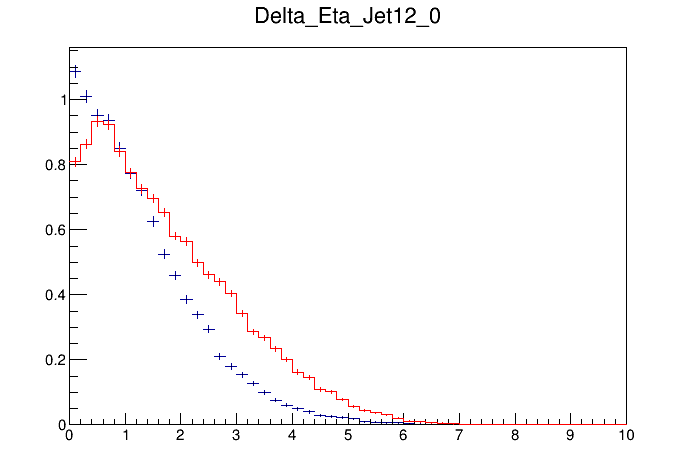

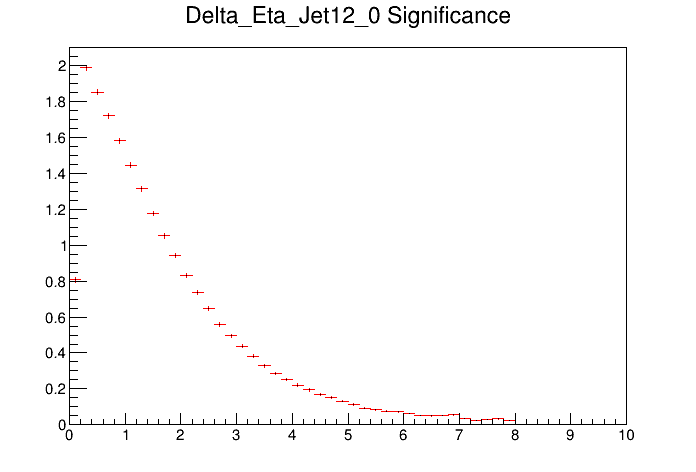

In [7]:
fList = open(imgPath + "fileList.txt","w+")
k=0
for f in os.listdir(signalPath):
    if os.path.isfile(signalPath + f) and '.root' in f:
        fList.write('%d\t%s\r\n'%(k,f))
        k+=1
fList.close()

for k in range(len(hsDeltaEtaJet)):
    HzsDEta = hsDeltaEtaJet[k].Clone()
    HzbDEta = hbDeltaEtaJet.Clone()
#     Histos(HzsDEta,HzbDEta, imgFold[k] + '/deltaEta_j12.png')
    PlotHistos(HzsDEta,HzbDEta,save=True,savePath=imgFold[k])
#     Hz = Sig(HzsDEta, HzbDEta, ns=ns[k], nb=nb)
#     Histo(Hz,imgFold[k] + '/z_DeltaEta_j1_j2.png')
    Hz = Significance(HzsDEta, HzbDEta, ns=ns[k], nb=nb)
    PlotHisto(Hz,save=True,savePath=imgFold[k])

### Delta Eta maximum invariant mass jet

Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDeltaEtaM_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hbDeltaEtaMaxIMsignificance.png has been created


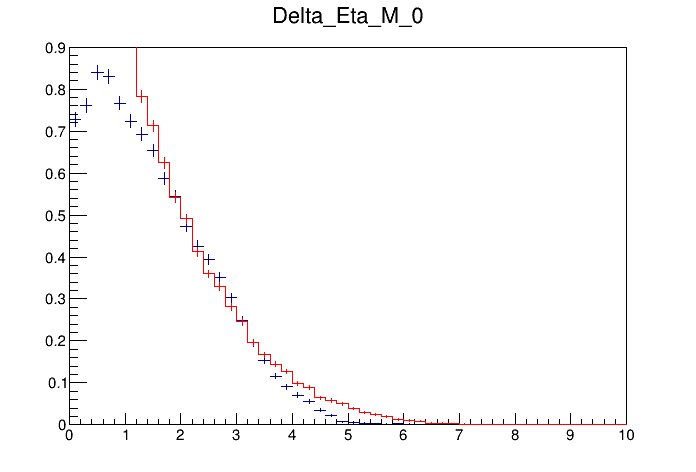

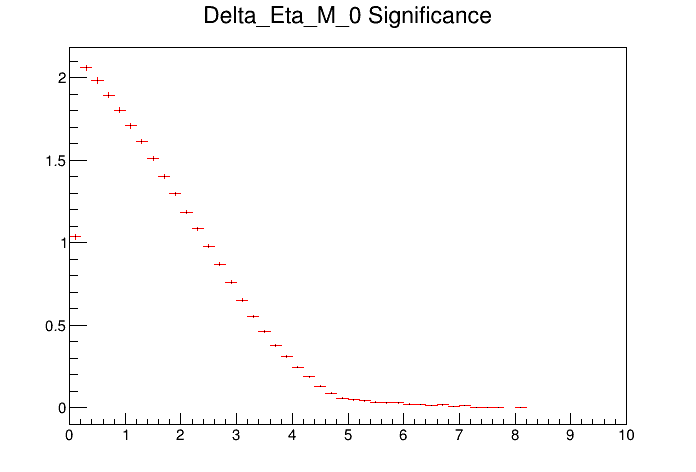

In [8]:
for k in range(len(hsDeltaEtaJet)):
    HzsMass = hsDeltaEtaMaxIM[k].Clone()
    HzbMass = hbDeltaEtaMaxIM.Clone()
#     Histos(HzsMass,HzbMass, imgFold[k] + '/deltaEta_MaxIM.png')
#     Hz = Sig(HzsMass, HzbMass, ns=ns[k], nb=nb)
#     Histo(Hz,imgFold[k] + '/z_DeltaEta_maxMassInv.png')
    PlotHistos(HzsMass,HzbMass,save=True,savePath=imgFold[k])
    Hz = Significance(HzsMass, HzbMass, ns=ns[k], nb=nb)
    PlotHisto(Hz,save=True,savePath=imgFold[k])

## Invariant Mass

Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hSMass_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hbMasssignificance.png has been created


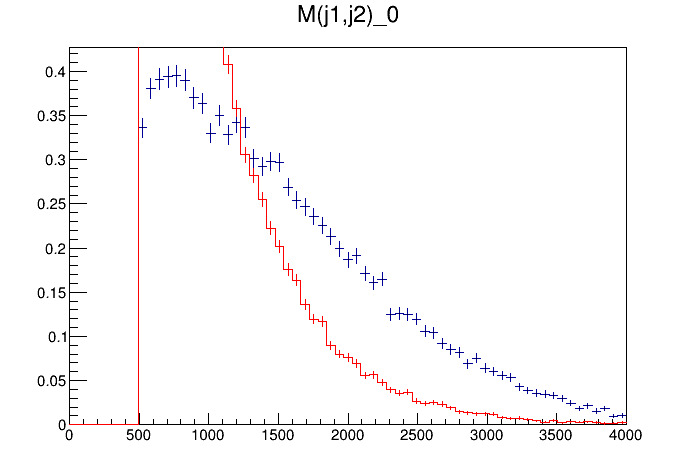

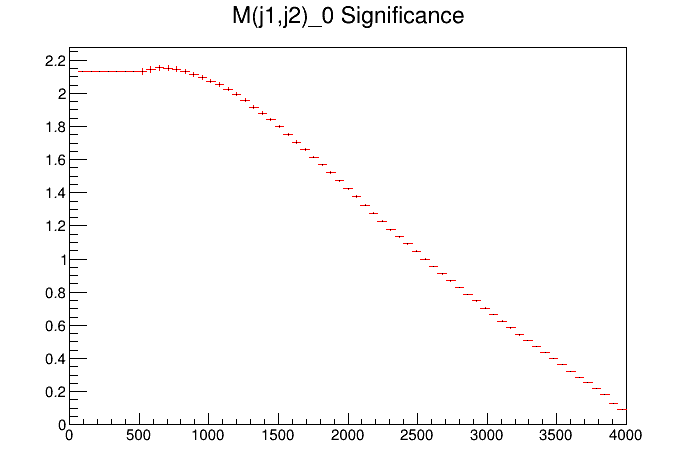

In [9]:
for k in range(len(hsDeltaEtaJet)):
    HsMass = hsMass[k].Clone()
    HbMass = hbMass.Clone()
#     Histos(HsMass,HbMass, imgFold[k] + '/m_j1_j2.png')
#     HzM = Sig(HsMass, HbMass, ns=ns[k], nb=nb)
#     Histo(HzM,imgFold[k] + '/z_m_j1_j2.png')
    PlotHistos(HsMass,HbMass, save=True,savePath=imgFold[k])
    HzM = Significance(HsMass, HbMass, ns=ns[k], nb=nb)
    PlotHisto(HzM,save=True,savePath=imgFold[k])

### Maximum invariant mass

Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsMjj_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hbMjjsignificance.png has been created


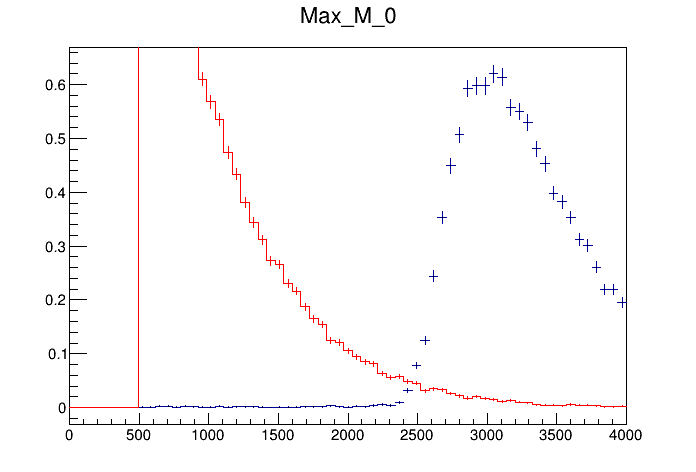

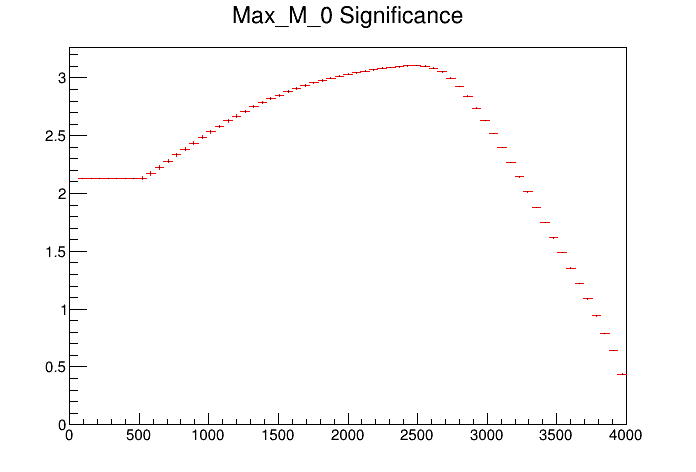

In [10]:
for k in range(len(hsDeltaEtaJet)):
    HsMass = hsMassMax[k].Clone()
    HbMass = hbMassMax.Clone()
#     Histos(HsMass,HbMass, imgFold[k] + '/m_max.png')
#     HzM = Sig(HsMass, HbMass, ns=ns[k], nb=nb)
#     Histo(HzM,imgFold[k] + '/z_m_maxMassInv.png')
    PlotHistos(HsMass,HbMass,save=True,savePath=imgFold[k])
    HzM = Significance(HsMass, HbMass, ns=ns[k], nb=nb)
    PlotHisto(HzM,save=True,savePath=imgFold[k])

### Delta Phi

Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDeltaPhi_0.png has been created


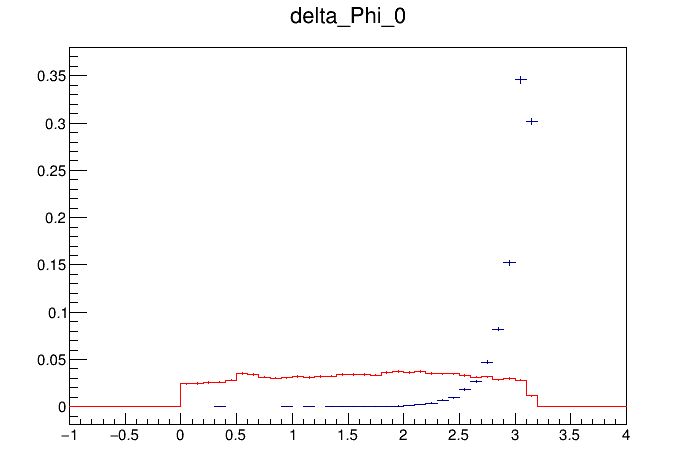

In [12]:
for k in range(len(hsDeltaEtaJet)):
    HzsPhi = hsDeltaPhi[k].Clone()
    HzbPhi = hbDeltaPhi.Clone()
#     Histos(HzsPhi,HzbPhi, imgFold[k] + '/deltaPhi(j1,j2).png')
    PlotHistos(HzsPhi,HzbPhi, save=True,savePath=imgFold[k])

### Delta Phi maximum invariant mass for two jets

Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDeltaPhiMax_0.png has been created


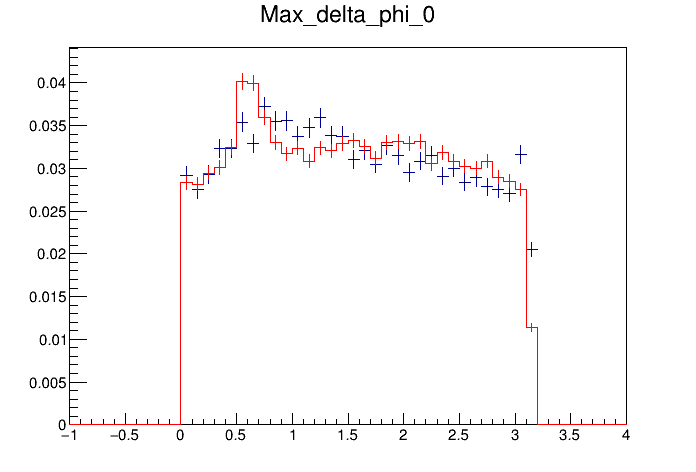

In [13]:
for k in range(len(hsDeltaEtaJet)):
    HzsPhi = hsDeltaPhiMax[k].Clone()
    HzbPhi = hbDeltaPhiMax.Clone()
#     Histos(HzsPhi,HzbPhi, imgFold[k] + '/deltaPhi__max.png')
    PlotHistos(HzsPhi,HzbPhi, save=True,savePath=imgFold[k])

### DeltaPhi(Met,Jet)

Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDelPhiMet_j0_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDelPhiMet_j1_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDelPhiMet_j2_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDelPhiMet_j3_0.png has been created
Info in <TCanvas::Print>: png file ./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020hsDelPhiMet_j4_0.png has been created


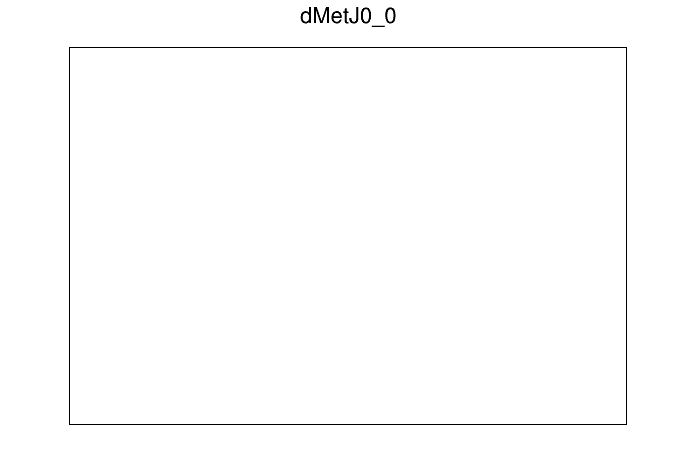

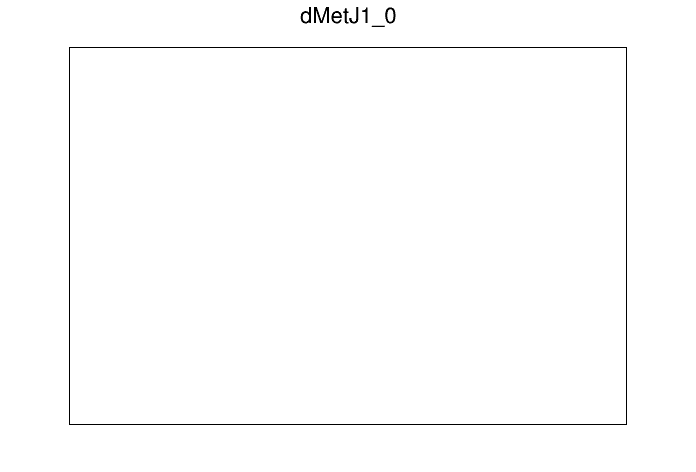

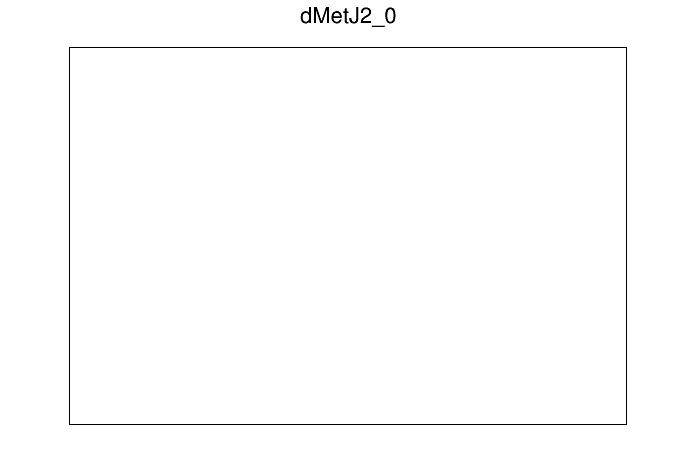

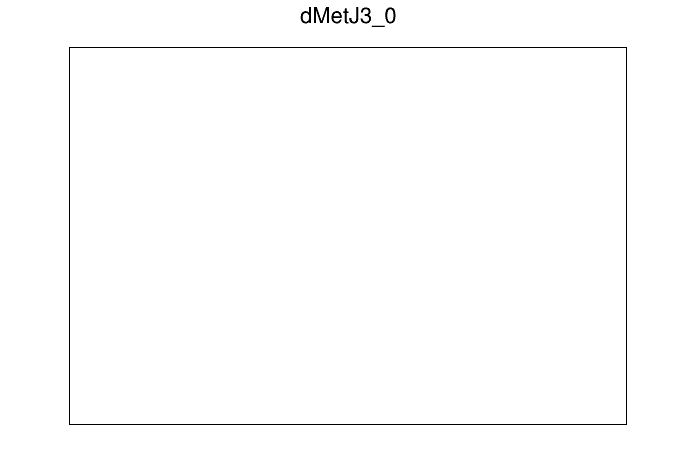

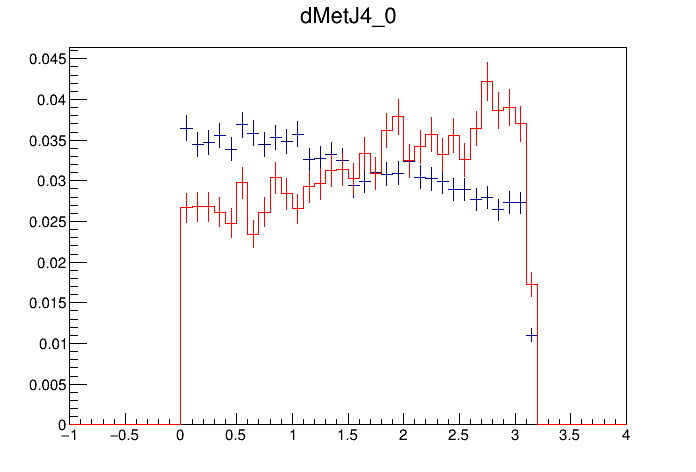

In [20]:
for k in range(len(hsDeltaEtaJet)):
    for n in range(numJets):
        HzsPhi = hsDeltaPhiMetJet[k][n].Clone()
        HzbPhi = hbDeltaPhiMetJet[n].Clone()
#         Histos(HzsPhi,HzbPhi, imgFold[k] + '/deltaPhiMet_J{0}.png'.format(n))
        PlotHistos(HzsPhi,HzbPhi, save=True,savePath=imgFold[k])
        

In [16]:
def Histos(hs, hb,savePath=None):
    """
    Description: Plot the two histograms hs and hb
                 in the same canvas
    """
    canvas = ROOT.TCanvas()
    canvas.cd()
    hs.Scale(1/hs.Integral())
    hb.Scale(1/hb.Integral())
    hs.SetStats(0)
    hb.SetStats(0)
    hb.SetLineColor(2)
    hs.SetMaximum(MaxValueHist(hs, hb))
    hs.SetLineColor(1)
#     hs.Draw("text")
    hs.Draw()
    hb.Draw("h,same")
    
    legend = ROOT.TLegend(0.6,0.6,0.9,0.9)
    #legend.AddEntry(hss, "Signal")
    #legend.AddEntry(hbb, "Background")
    legend.Draw()
    canvas.Update()
#     canvas.Draw()
    if savePath != None:
        canvas.SaveAs(savePath)
    #gROOT.GetListOfCanvases().Draw()

In [21]:
imgFold[0]

'./images/spin0/23-04-2020/DMSimpSpin0_MY5000_MX1000_07042020/noCuts/DMSimpSpin0_MY5000_MX1000_07042020'